In [20]:
import random
from utils.snowflake_funcs import snowflake_connector  
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

## Load data

In [ ]:
# load data from the database by SQL

## Data preprocessing

In [ ]:
# encode categorical variables

df_encoded = pd.get_dummies(data, columns=['PLATFORM', 'COUNTRY_CODE', 'DEVICE_TYPE'])
df_encoded.head()

In [8]:
df_en = df_encoded.copy()

In [ ]:
## delete rows with strange install date

df_en['INSTALL_DATE'] = pd.to_datetime(df_en['INSTALL_DATE'])
cutoff_date = pd.to_datetime('2024-04-07')
df_correct_date = df_en.loc[df_en['INSTALL_DATE'] <= cutoff_date, ]

# label new users
cutoff_date = pd.to_datetime('2024-04-01')
df_correct_date.loc[df_correct_date['INSTALL_DATE'] >= cutoff_date, 'NEW_USERS'] = 1
df_correct_date.loc[df_correct_date['INSTALL_DATE'] < cutoff_date, 'NEW_USERS'] = 0

## Build machine learning model to predict pre-experiment data of new users

In [ ]:
# Split the data to train and test sets based on new or existin users
# existing users are allocated to the train group; new users are allocated to the test group

train = df_correct_date.loc[df_correct_date['NEW_USERS']==0, ]
test = df_correct_date.loc[df_correct_date['NEW_USERS']==1, ]
test.head()

In [12]:
# Fill in the missing values of the previous number of games starting with 0 in the train set, 
# representing that those are existing players who didn't play during the pre-experiemnt data collection period

train['PRE_NUM_GAME_START'] = train['PRE_NUM_GAME_START'].fillna(0)
train['PRE_NUM_GAME_START'].isna().sum()

/var/folders/vx/w5z5d3dd317gflztcs29ll8h0000gn/T/ipykernel_7871/1666124619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['PRE_NUM_GAME_START'] = train['PRE_NUM_GAME_START'].fillna(0)


0

In [13]:
# Select columns that are going to use in the machine learning model
categorical_variables = list(df_encoded.columns)
categorical_variables.remove('INSTALL_PK')
categorical_variables.remove('PRE_NUM_GAME_START')
categorical_variables.remove('INSTALL_DATE')
print(categorical_variables)

['NUM_GAME_START', 'COHORT_DAY', 'PLATFORM_android', 'PLATFORM_ios', 'COUNTRY_CODE_AD', 'COUNTRY_CODE_AE', 'COUNTRY_CODE_AF', 'COUNTRY_CODE_AG', 'COUNTRY_CODE_AI', 'COUNTRY_CODE_AL', 'COUNTRY_CODE_AM', 'COUNTRY_CODE_AO', 'COUNTRY_CODE_AQ', 'COUNTRY_CODE_AR', 'COUNTRY_CODE_AS', 'COUNTRY_CODE_AT', 'COUNTRY_CODE_AU', 'COUNTRY_CODE_AW', 'COUNTRY_CODE_AX', 'COUNTRY_CODE_AZ', 'COUNTRY_CODE_BA', 'COUNTRY_CODE_BB', 'COUNTRY_CODE_BD', 'COUNTRY_CODE_BE', 'COUNTRY_CODE_BF', 'COUNTRY_CODE_BG', 'COUNTRY_CODE_BH', 'COUNTRY_CODE_BI', 'COUNTRY_CODE_BJ', 'COUNTRY_CODE_BL', 'COUNTRY_CODE_BM', 'COUNTRY_CODE_BN', 'COUNTRY_CODE_BO', 'COUNTRY_CODE_BQ', 'COUNTRY_CODE_BR', 'COUNTRY_CODE_BS', 'COUNTRY_CODE_BT', 'COUNTRY_CODE_BW', 'COUNTRY_CODE_BY', 'COUNTRY_CODE_BZ', 'COUNTRY_CODE_CA', 'COUNTRY_CODE_CD', 'COUNTRY_CODE_CF', 'COUNTRY_CODE_CG', 'COUNTRY_CODE_CH', 'COUNTRY_CODE_CI', 'COUNTRY_CODE_CK', 'COUNTRY_CODE_CL', 'COUNTRY_CODE_CM', 'COUNTRY_CODE_CN', 'COUNTRY_CODE_CO', 'COUNTRY_CODE_CR', 'COUNTRY_CODE_CU', 

In [ ]:
# Build a XGBoost model
X_train = train[categorical_variables]
X_test = test[categorical_variables]

y_train = train['PRE_NUM_GAME_START']
model = xgb.XGBRegressor()
model.fit(X_train,y_train)
test["PRE_NUM_GAME_START"] = model.predict(X_test)
test.head()


In [ ]:
# Combine train and test datasets to get an entire dataset that includes all users and no missing values in 'PRE_NUM_GAME_START'
frames = [train, test]
df_no_missing = pd.concat(frames)
df_no_missing

## CUPED adjustment

In [16]:
# identical function with the one in Model 3, 'aa_test_cuped.ipynb'
def get_cupac_adjusted(data, covariate):
    theta = data[covariate].cov(data['NUM_GAME_START']) / data[covariate].var()
    data['ADJUSTED_NUM_GAME_START'] = data['NUM_GAME_START'] - theta * (data[covariate] - data[covariate].mean())
    
    return data

In [ ]:
# gat CUPED adjusted target metric
final_data = get_cupac_adjusted(df_no_missing, 'PRE_NUM_GAME_START')

## Calculate metric

In [18]:
def calculate_avg_new_game_start(data):
    total_game_start = data['ADJUSTED_NUM_GAME_START'].sum()
    total_users = data['INSTALL_PK'].nunique()

    return total_game_start/total_users

## A/A test

In [19]:
# main
game_start_difference_cupac = []

for i in range(0, 1000):
    print(i)
    
    # split data to treatment and control groups randomly
    treatment, control = train_test_split(final_data, test_size=0.5, shuffle=True)

    # calculate the mean of target metric
    t_game_start = calculate_avg_new_game_start(treatment)
    c_game_start = calculate_avg_new_game_start(control)

    # store the difference
    game_start_difference_cupac.append(t_game_start - c_game_start)
    
game_start_difference_cupac

0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


[0.003281019639985061,
 -0.01847880343725805,
 0.020642695030797853,
 -0.0691706525595599,
 -0.00488653809261308,
 0.055395663056074795,
 0.017624918617443086,
 0.017918781909994408,
 0.041988170510130374,
 -0.011678042222836638,
 -0.044944982758337915,
 -0.017007946048426703,
 0.025730582730663087,
 -0.015768880798592733,
 -0.003838414671616164,
 -0.011836626762658398,
 -0.03484558862235332,
 -0.0560372757029306,
 0.006350853367781184,
 0.02344664881724512,
 -0.011306746909255594,
 -0.016947200723887335,
 0.029441476214472573,
 0.0027574370811649374,
 0.038988087233914115,
 0.0032460221192458505,
 0.023863903927818342,
 -0.01380785214268343,
 -0.019801308798896855,
 -0.00837131160634641,
 0.021964913405742692,
 -0.021486452533121536,
 0.03331603966124774,
 0.048641753446663216,
 0.021773012098499578,
 -0.010956832073418354,
 0.024942957684480405,
 -0.005348509922175282,
 0.007382517819678469,
 0.00702522594646382,
 -0.013182420834670694,
 -0.005337093496951439,
 -0.003124871696336129,

## Result visualisation

<Axes: ylabel='Density'>

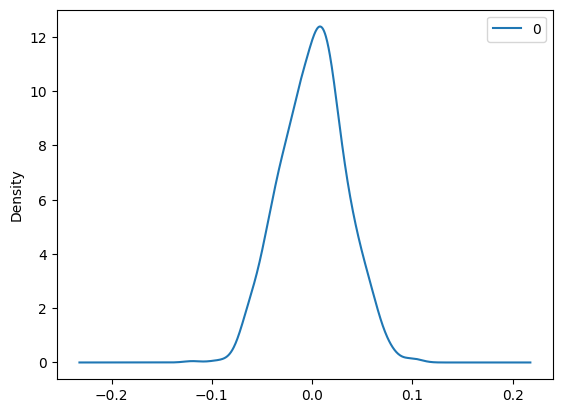

In [20]:
df_game_start_difference_cuped_ml = pd.DataFrame(game_start_difference_cupac,dtype=float)
df_game_start_difference_cuped_ml.plot.kde()

/var/folders/vx/w5z5d3dd317gflztcs29ll8h0000gn/T/ipykernel_1181/3280962828.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_game_start_difference_cuped_ml)


Text(0, 0.5, 'Density')

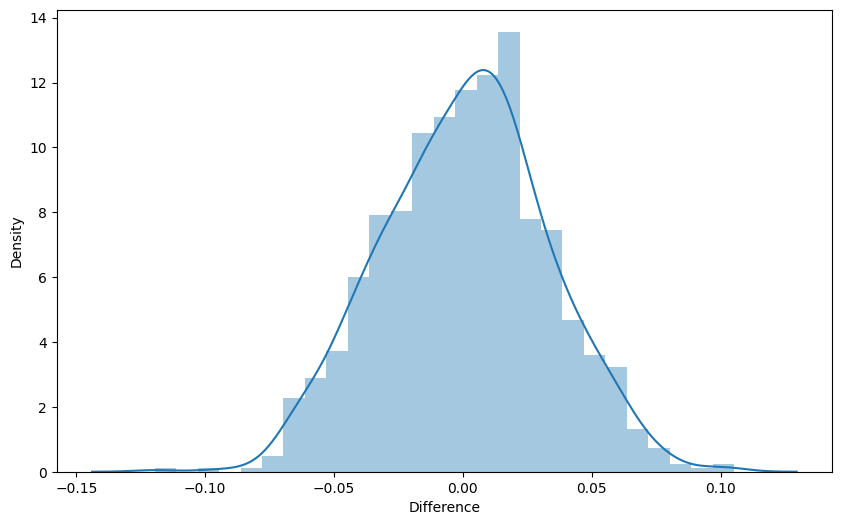

In [22]:
plt.figure(figsize=(10, 6))
sns.distplot(df_game_start_difference_cuped_ml)
plt.xlabel('Difference')
plt.ylabel('Density')

In [21]:
df_game_start_difference_cuped_ml.to_pickle('result/model4.pkl')